# Market Stress Detection Using Machine Learning

This notebook builds an warning system that estimates the probability of market stress using volatility, drawdowns, and cumulative losses.
It has an intention of education more than a predictor, it gave me some practice to fine my python skills, ML and finance knowledge.


## 1. Libraries and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("data/sp500.csv")
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/29/2025,"6,905.74","6,903.60","6,920.21","6,888.76",NaN,-0.35%
1,12/26/2025,"6,929.94","6,936.02","6,945.77","6,921.60",NaN,-0.03%
2,12/24/2025,"6,932.05","6,904.91","6,937.32","6,904.91",NaN,0.32%
3,12/23/2025,"6,909.79","6,872.41","6,910.88","6,868.81",NaN,0.46%
4,12/22/2025,"6,878.49","6,865.21","6,882.03","6,855.74",NaN,0.64%


## 2. Feature Engineering

Rolling volatility, cumulative returns, and drawdowns are used as risk indicators commonly monitored by market risk teams.


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4527 entries, 0 to 4526
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      4527 non-null   object 
 1   Price     4527 non-null   object 
 2   Open      4527 non-null   object 
 3   High      4527 non-null   object 
 4   Low       4527 non-null   object 
 5   Vol.      0 non-null      float64
 6   Change %  4527 non-null   object 
dtypes: float64(1), object(6)
memory usage: 247.7+ KB


In [3]:
# Columns that should be numeric

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)


df = df.drop(columns=["Vol.", "Change %"])

num_cols = ["Price", "Open", "High", "Low"]

for col in num_cols:
    df[col] = (
        df[col]
        .str.replace(",", "", regex=False)
        .astype(float)
    )

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4527 entries, 0 to 4526
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4527 non-null   datetime64[ns]
 1   Price   4527 non-null   float64       
 2   Open    4527 non-null   float64       
 3   High    4527 non-null   float64       
 4   Low     4527 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 177.0 KB


In [4]:
df = df.rename(columns={"Price": "price"})

df["ret"] = np.log(df["price"] / df["price"].shift(1))
df = df.dropna()

df.head()


,Date,price,Open,High,Low,ret
1,2008-01-03,1447.2,1447.5,1456.8,1443.7,0.000000
2,2008-01-04,1411.6,1444.0,1444.0,1411.2,-0.024907
3,2008-01-07,1416.2,1414.1,1423.9,1403.5,0.003253
4,2008-01-08,1390.2,1415.7,1430.3,1388.3,-0.018530
5,2008-01-09,1409.1,1390.2,1409.2,1378.7,0.013504


In [5]:
# Rolling volatility
df["vol_10"] = df["ret"].rolling(10).std()
df["vol_20"] = df["ret"].rolling(20).std()

# Rolling cumulative return (drawdown proxy)
df["ret_20"] = df["ret"].rolling(20).sum()

# Rolling drawdown
df["drawdown_20"] = df["price"] / df["price"].rolling(20).max() - 1

df = df.dropna()

df.head()


,Date,price,Open,High,Low,ret,vol_10,vol_20,ret_20,drawdown_20
20,2008-01-31,1378.5,1352.0,1385.6,1334.1,0.016604,0.016602,0.015479,-0.048635,-0.047471
21,2008-02-01,1395.4,1378.6,1396.0,1375.9,0.012185,0.013118,0.015816,-0.036450,-0.017532
22,2008-02-04,1380.8,1395.4,1395.4,1379.7,-0.010518,0.013590,0.015018,-0.022061,-0.027811
23,2008-02-05,1336.6,1380.3,1380.3,1336.6,-0.032534,0.017404,0.016527,-0.057848,-0.058931
24,2008-02-06,1326.5,1339.5,1352.0,1324.3,-0.007585,0.016208,0.016159,-0.046904,-0.066042


## 3. Stress Definition (Target)
Market stress is defined using a rule-based approach based on sustained losses and extreme volatility. 


In [6]:
vol_threshold = df["vol_20"].quantile(0.95)

df["stress"] = (
    (df["ret_20"] < -0.05) |
    (df["vol_20"] > vol_threshold)
).astype(int)

df["stress"].value_counts()

stress
0    3972
1     535
Name: count, dtype: int64

In [7]:
df.head()


,Date,price,Open,High,Low,ret,vol_10,vol_20,ret_20,drawdown_20,stress
20,2008-01-31,1378.5,1352.0,1385.6,1334.1,0.016604,0.016602,0.015479,-0.048635,-0.047471,0
21,2008-02-01,1395.4,1378.6,1396.0,1375.9,0.012185,0.013118,0.015816,-0.036450,-0.017532,0
22,2008-02-04,1380.8,1395.4,1395.4,1379.7,-0.010518,0.013590,0.015018,-0.022061,-0.027811,0
23,2008-02-05,1336.6,1380.3,1380.3,1336.6,-0.032534,0.017404,0.016527,-0.057848,-0.058931,1
24,2008-02-06,1326.5,1339.5,1352.0,1324.3,-0.007585,0.016208,0.016159,-0.046904,-0.066042,0


## 5. Train/Test Split

A date based train/test split is used to simulate real-time deployment and avoid future bias.


In [8]:
features = ["vol_10", "vol_20", "ret_20", "drawdown_20"]
X = df[features]
y = df["stress"]

split_date = df["Date"].quantile(0.80)

train = df[df["Date"] < split_date]
test  = df[df["Date"] >= split_date]

X_train, y_train = train[features], train["stress"]
X_test, y_test   = test[features], test["stress"]


In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]


In [10]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

pr_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precision[:-1],
    "recall": recall[:-1]
})

pr_df


,threshold,precision,recall
0,0.105459,0.105322,1.000000
1,0.127675,0.105438,1.000000
2,0.131395,0.105556,1.000000
3,0.133140,0.105673,1.000000
4,0.136078,0.105791,1.000000
...,...,...,...
897,0.885332,1.000000,0.052632
898,0.893687,1.000000,0.042105
899,0.898892,1.000000,0.031579
900,0.914011,1.000000,0.021053


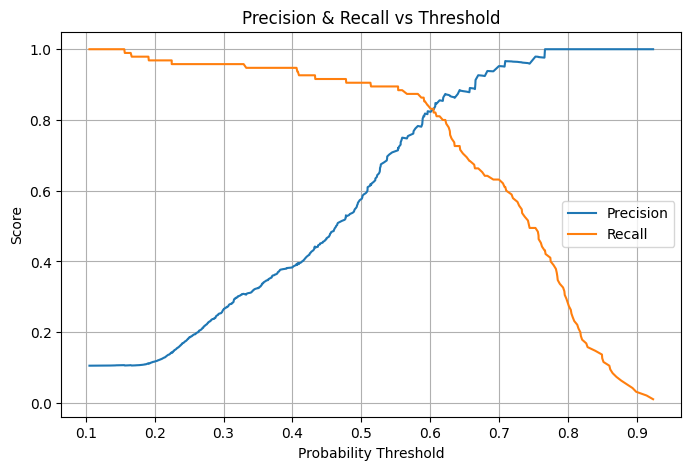

In [11]:
plt.figure(figsize=(8,5))

plt.plot(pr_df["threshold"], pr_df["precision"], label="Precision")
plt.plot(pr_df["threshold"], pr_df["recall"], label="Recall")

plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid(True)

plt.show()


In [13]:
# Predict stress probability for all observations
df["stress_prob"] = model.predict_proba(df[features])[:, 1]
recent = df[["Date", "stress_prob", "stress"]].tail(10)
recent


,Date,stress_prob,stress
4517,2025-12-15,0.286036,0
4518,2025-12-16,0.282930,0
4519,2025-12-17,0.333258,0
4520,2025-12-18,0.297962,0
4521,2025-12-19,0.230291,0
4522,2025-12-22,0.215528,0
4523,2025-12-23,0.219614,0
4524,2025-12-24,0.227089,0
4525,2025-12-26,0.238067,0
4526,2025-12-29,0.261640,0


In [26]:

df["stress_prob_%"] = (df["stress_prob"] * 100).round(1)


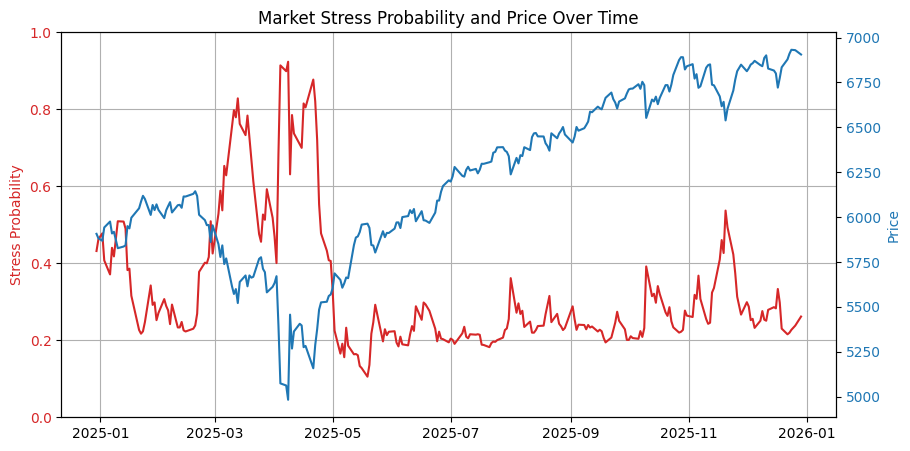

In [ ]:
import matplotlib.pyplot as plt

recent_df = df.tail(250)  

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(
    recent_df["Date"],
    recent_df["stress_prob"],
    color="tab:red",
    label="Stress Probability"
)
ax1.set_ylabel("Stress Probability", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
ax2.plot(
    recent_df["Date"],
    recent_df["price"],
    color="tab:blue",
    label="Market Price"
)
ax2.set_ylabel("Price", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

plt.title("Market Stress Probability and Price Over Time")
ax1.grid(True)

plt.show()


- Risk increases before prices clearly fall, meaning markets can look calm while becoming fragile.
- High risk usually lasts for several days, not just one, showing that stressful conditions tend to persist.
- From May to December, market stress remained relatively low while prices increased consistenly, showing a more stable market environment compared to earlier periods, which were probably caused by the tariffs.